In [53]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML


#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
episode_length = 30
seed = 42

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[42]

In [3]:
def leftmost_emptiest_tank_policy(s, system):
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]
    #n_min = len(min_indexes)

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        #print(hypothetical_next_tank_state, system.tank_max_loads[tank_visited])
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return tank_to_go
    else:
        return system.n #stay in the depot

# Creating train, validation and test sets

In [4]:
################################################################################
# ENSURE THIS PARAMETER VALUES ARE SET AT THE BEGINNING OF THE pdsystem_env.py!!
################################################################################

# Example k = 1 (trucks), n = 3 (tanks)
TANK_MAX_LOADS = np.array([100., 200, 100.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9]
                                                   ])
TRUCK_MAX_LOADS = np.array([50.])
GRAPH_WEIGHTS = np.array([32., 159., 162., 0.])

DISCRETE = False
########################################

In [5]:
seed = 42
np.random.seed(seed)
system = PDSystemEnv()

N_TRAIN = 10**4; SEED_TRAIN = 42; train_file = 'train.txt'
N_VAL = 10**3; SEED_VAL = 50; validation_file = 'validation.txt'
N_TEST = 10**3; SEED_TEST = 58; test_file = 'test.txt'

round_decimals = 5

CREATE_DATASETS = False

def create_datasets(outputfile, n_observations, seed = None):   
    if seed != None:
        np.random.seed(seed)
        
    with open('{}'.format(outputfile),'w') as f:
        np.savetxt(f, [np.array(['tank1', 'tank2', 'tank3', 'target'])], fmt = "%s", delimiter=',')
        for i in range(n_observations):
            obs = []
            for max_load in TANK_MAX_LOADS:
                random_load = np.random.random() * max_load
                obs.append(np.round(random_load,round_decimals)  )

            obs.append(leftmost_emptiest_tank_policy(np.array(obs), system))   
            np.savetxt(f, [np.array(obs)], fmt = ('%f','%f', '%f', '%d'), delimiter=',')  #!! fmt only for n=3

if CREATE_DATASETS:          
    create_datasets(train_file, N_TRAIN, SEED_TRAIN) 
    create_datasets(validation_file, N_VAL, SEED_VAL)      
    create_datasets(test_file, N_TEST, SEED_TEST)            

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Exploring data sets

In [6]:
import pandas as pd

In [7]:
train = pd.read_table(train_file, sep = ",")
test = pd.read_table(test_file, sep = ",")
validation = pd.read_table(validation_file, sep = ",")

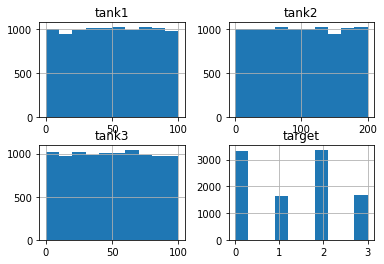

In [8]:
train.hist()
plt.show()

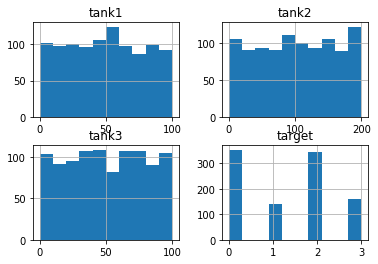

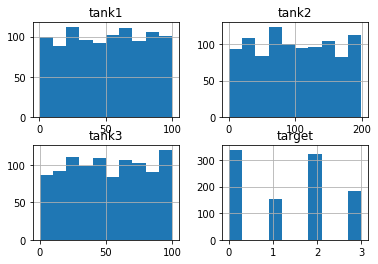

In [20]:
test.hist()
validation.hist()

plt.show()

In [38]:
y_train = train["target"].values#.reshape((N_TRAIN, ))
X_train = train[["tank1", "tank2","tank3"]].values

y_test = test["target"].values#.reshape((N_TEST, ))
X_test = test[["tank1", "tank2","tank3"]].values

y_val = validation["target"]#.reshape((N_VAL, ))
X_val = validation[["tank1", "tank2","tank3"]].values

# Stochastic gradient descent classifier 

In [54]:
from sklearn.linear_model import SGDClassifier

In [70]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [56]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train);

## Cross validation accuracy

In [61]:
CV = 10

In [62]:
cvs = cross_val_score(sgd_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.805050233881416


In [63]:
from sklearn.preprocessing import StandardScaler


In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [65]:
cvs = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9026149060019663


## Error Analysis

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3218,   33,   64,    8],
       [ 112, 1420,   45,   66],
       [ 198,   89, 3027,   52],
       [ 188,   64,   55, 1361]])

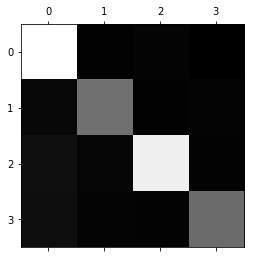

In [72]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [74]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

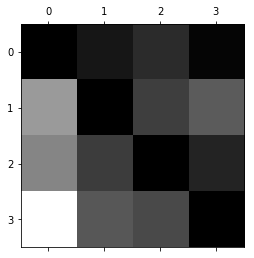

In [75]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()